## ST_BUFFER_SQUASHED
Normal buffer offers 3 end cap styles: flat, round, box.
<br>https://shapely.readthedocs.io/en/stable/reference/shapely.buffer.html

Here's a 3rd method between round and flat- squashed.
<br>The idea is to use a second distance (or "radius"), smaller than the normal buffer radius, 
<br>to define how far the round cap should extend past the end of the underlying line.

Let's demonstrate

In [24]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

import shapely
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

Define a generic linestring and get your traditional buffers

In [11]:
points = [(0, 0), (1, 1), (2, 2), (3, 3)]
line = LineString(points)

x, y = line.xy

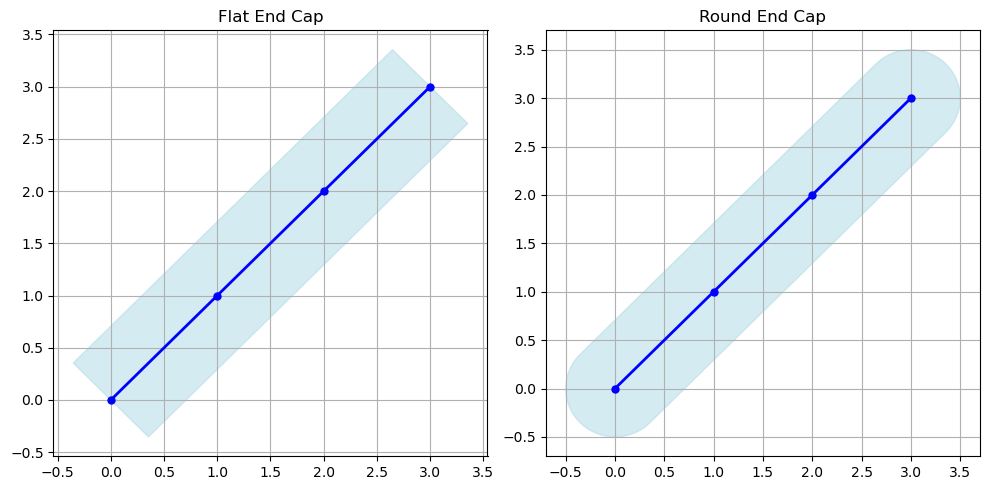

In [13]:
buffer_flat = line.buffer(0.5, cap_style='flat') #round, square, flat
buffer_round = line.buffer(0.5, cap_style='round')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the LineString
axs[0].plot(x, y, color='blue', linewidth=2, marker='o', markersize=5)
axs[1].plot(x, y, color='blue', linewidth=2, marker='o', markersize=5)

# Plot buffers
buffer_patch_flat = MplPolygon(list(buffer_flat.exterior.coords), color='lightblue', alpha=0.5)
axs[0].add_patch(buffer_patch_flat)
buffer_patch_round = MplPolygon(list(buffer_round.exterior.coords), color='lightblue', alpha=0.5)
axs[1].add_patch(buffer_patch_round)

axs[0].set_title('Flat End Cap')
axs[1].set_title('Round End Cap')

plt.tight_layout()
axs[0].grid(True)
axs[1].grid(True)
plt.show()

For squashed ends, imagine a flat line and a circle defined with a new center and larger radius

Imagine a linestring that's straight, starts at the origina dn extends along the positive x axis.

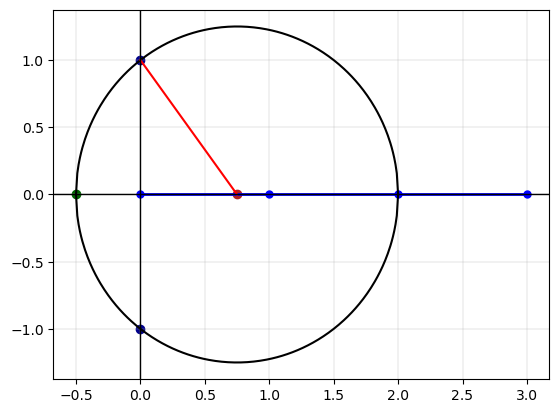

In [19]:
buffer_radius = 1
end_cap_radius = 0.5

x_center = (buffer_radius-end_cap_radius**2)/(2*end_cap_radius) ### distance translated backward up linestring from starting linestring point
radius = np.sqrt(x_center**2 + buffer_radius**2) # the radius of the circle that will define the end cap

x = np.arange(-1*end_cap_radius, radius + x_center, 0.01)
y = np.sqrt(radius**2 - (x - x_center)**2)
x = np.append(x, radius + x_center)
y = np.append(y, 0)

### plot the notional linestring
plt.plot([0,1,2,3], [0,0,0,0], color='blue', linewidth=2, marker='o', markersize=5)

plt.plot(x,y, color = "black")
plt.plot(x,-1*y, color = "black")
### circle center
plt.scatter(x_center, 0, color='firebrick')
### where squashed cap intersects x axis
plt.scatter(-1*end_cap_radius, 0, color='darkgreen')
### ends of the normal buffer
plt.scatter([0,0], [-1*buffer_radius,buffer_radius], color='darkblue')
plt.plot([x_center, 0], [0, buffer_radius], color = "red") ### draw another radius of the circle and a hypotenuse of a triangle
plt.axhline(0, color='black',linewidth=1)  # X-axis
plt.axvline(0, color='black',linewidth=1)  # Y-axis

plt.grid(True, linewidth=0.25)
plt.show()

There are plenty of definitions for defining circles from 3 points (eg using bisectors), but those require identifying the points of the corners of the flat buffer.
<br>Using this approach, we only need points from the linestring. We never have to parse out points from buffers.

The idea here is given how long the buffer radius and the end cap radius are, know how far to translate back from the end of the linestring 
<br>(technically, along a tangent of the first 2 points of the linestring)
This distance is "x_center" of the x coordinate of the center of the circle.

Note the relationships x_center and radius.

There are 2 key relationships used to get the x_center and radius definitions.
<br>First, we know: 
<br>x_center + end_cap_radius = radius

In the graph above, the distance from circle center to where the circle intersects the x axis (in negative x space) must be the radius of that circle.


<br>The second relationship is the right triangle formed between the origin, the center of the circle, and the normal buffer's radius (or half-width of that buffer polygon).
<br>(The red hypotenuse in the graph above is alsoe a circle radius.)
<br>**radius<sup>2</sup> = x_center<sup>2</sup> + buffer_radius<sup>2</sup>** 

Using substitution, it's not easy to define x_center as a function of end_cap_radius
<br>x_center = (buffer_radius-end_cap_radius<sup>2</sup>)/(2 * end_cap_radius)
<br>or more simple
<br>end_cap_radius = sqrt(x_center<sup>2</sup> + buffer_radius<sup>2</sup>) - x_center

This is the basic idea, let's build it out.

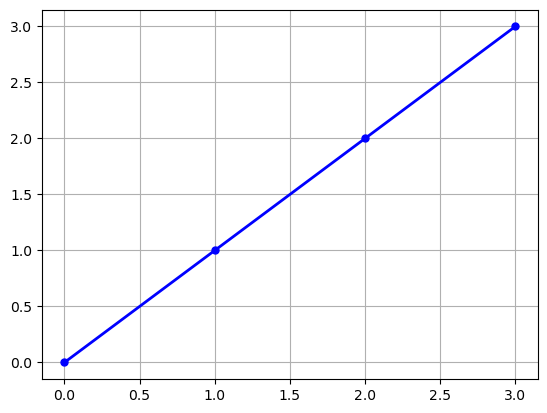

In [22]:
points = [(0, 0), (1, 1), (2, 2), (3, 3)]
line = LineString(points)
x, y = line.xy
plt.plot(x, y, color='blue', linewidth=2, marker='o', markersize=5)

# Show the plot
plt.grid(True)
plt.show()

Extract first & last 2 points of linestring.
<br>Apply logic as discussed above to get definitions of end cap circles.

In [26]:
### extract first 2 and last 2 lines from linestring
first_two_points = list(line.coords[:2])
line_first_two_points = LineString(first_two_points)
first_two_x, first_two_y = line_first_two_points.xy
    
last_two_points = list(line.coords[-2:])
line_last_two_points = LineString(last_two_points)
last_two_x, last_two_y = line_last_two_points.xy
    
### handle inf slope
### Not necessary if logic refactored as vector maths.
if first_two_x[1] == first_two_x[0]:
    first_two_x[1] += 0.000001
if last_two_x[1] == last_two_x[0]:
    last_two_x[1] += 0.000001
        
first_two_slope = (first_two_y[1] - first_two_y[0])/(first_two_x[1] - first_two_x[0])
last_two_slope = (last_two_y[1] - last_two_y[0])/(last_two_x[1] - last_two_x[0])

cap_buffer_ratio = end_cap_radius / buffer_radius
    
### distance to move off from first point or last point to get center of circle
circle_center_distance = (1-cap_buffer_ratio**2)/(2*cap_buffer_ratio) * buffer_radius
### radius of circle that will define squashed end
circle_radius = np.sqrt(circle_center_distance**2 + buffer_radius**2)

Find the center locations of start and end circles

In [27]:
### given the total backoff distance
### break into x and y components
start_posn_delta_x = np.sqrt(circle_center_distance**2 / (1 + first_two_slope**2))
if first_two_x[1] < first_two_x[0]:
    start_posn_delta_x *= -1
start_posn_delta_y = first_two_slope * start_posn_delta_x

end_posn_delta_x = np.sqrt(circle_center_distance**2 / (1 + last_two_slope**2))
if last_two_x[1] < last_two_x[0]:
    end_posn_delta_x *= -1
end_posn_delta_y = last_two_slope * end_posn_delta_x

start_circle_x_center = first_two_x[0] + start_posn_delta_x
start_circle_y_center = first_two_y[0] + start_posn_delta_y

end_circle_x_center = last_two_x[1] - end_posn_delta_x
end_circle_y_center = last_two_y[1] - end_posn_delta_y
    
start_circle_center = Point(start_circle_x_center, start_circle_y_center)
end_circle_center = Point(end_circle_x_center, end_circle_y_center)

In [28]:
# Create a circular polygon using the buffer method
start_circle = start_circle_center.buffer(circle_radius)
end_circle = end_circle_center.buffer(circle_radius)

Let's visualize results so far as a test to confirm the logic is working as expected

We should have 2 circles at either end of a flat buffer
<br>where the corners of the buffer intersect the start and end circles.

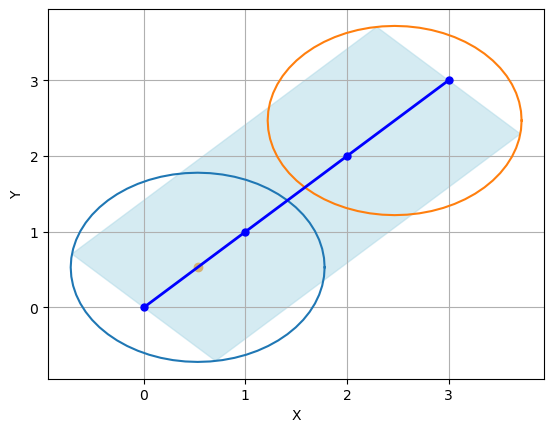

In [29]:
buffer = line.buffer(buffer_radius, cap_style='flat')

fig, ax = plt.subplots()

### plot the circles
x, y = start_circle.exterior.xy
ax.plot(x, y)
x, y = end_circle.exterior.xy
ax.plot(x, y)

### plot the linestring
x, y = line.xy
ax.plot(x, y, color='blue', linewidth=2, marker='o', markersize=5, label='LineString')
plt.scatter(start_circle_x_center, start_circle_y_center, color='darkorange')

# Plot the buffer as a filled polygon
buffer_patch = MplPolygon(list(buffer.exterior.coords), color='lightblue', alpha=0.5)
ax.add_patch(buffer_patch)

plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
plt.grid(True)
plt.show()

Given the circles, we can use spatial logic with various polygons to define the new, squashed buffer.
<br>("ST_" implies "spatial type" functions 

In [30]:
### st functions

### start with a flat buffer
buffer_flat = line.buffer(buffer_radius, cap_style='flat')

### define circles, similar to round end caps 
### 2 circles, from the first & last point of linestring
start_round = Point(first_two_x[0],first_two_y[0]).buffer(buffer_radius)
end_round = Point(last_two_x[1],last_two_y[1]).buffer(buffer_radius)

### use polygon difference from the flat buffer to only retain the semicircles
### these are the true "round end caps
buffer_difference_start = start_round.difference(buffer_flat)
buffer_difference_end = end_round.difference(buffer_flat)
    
### from our big circles from before
### only keep where round end caps and "squashed" large circles overlap
### these overlap polygons are the squashed end caps
start_cap_squashed = buffer_difference_start.intersection(start_circle)
end_cap_squashed = buffer_difference_end.intersection(end_circle)
   
### finally build the squashed buffer
### add the squashed end caps to the flat buffer polygon
final_squashed_buffer = buffer_flat.union(start_cap_squashed).union(end_cap_squashed)

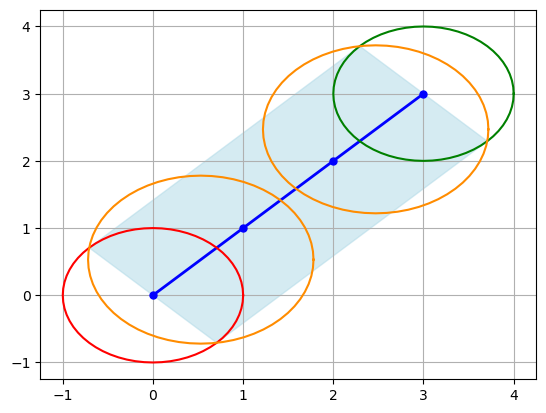

In [31]:
buffer = line.buffer(buffer_radius, cap_style='flat')

fig, ax = plt.subplots()

x, y = line.xy
ax.plot(x, y, color='blue', linewidth=2, marker='o', markersize=5, label='LineString')

x1, y1 = start_round.exterior.xy
ax.plot(x1, y1, color='red', label='flat')

x2, y2 = end_round.exterior.xy
ax.plot(x2, y2, color='green', label='flat')

x, y = start_circle.exterior.xy
ax.plot(x, y, color = "darkorange")
x, y = end_circle.exterior.xy
ax.plot(x, y, color = "darkorange")

buffer_patch = MplPolygon(list(buffer.exterior.coords), color='lightblue', alpha=0.5)
ax.add_patch(buffer_patch)

plt.grid(True)
plt.show()

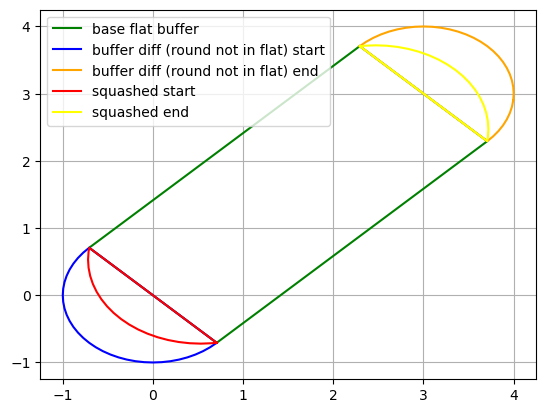

In [32]:
### test the buffer difference polygons
fig, ax = plt.subplots()

# Plot polygon2
x2, y2 = buffer_flat.exterior.xy
ax.plot(x2, y2, color='green', label='base flat buffer')

x1, y1 = buffer_difference_start.exterior.xy
ax.plot(x1, y1, color='blue', label='buffer diff (round not in flat) start')

x3, y3 = buffer_difference_end.exterior.xy
ax.plot(x3, y3, color='orange', label='buffer diff (round not in flat) end')

x4, y4 = start_cap_squashed.exterior.xy
ax.plot(x4, y4, color='red', label='squashed start')

x5, y5 = end_cap_squashed.exterior.xy
ax.plot(x5, y5, color='yellow', label='squashed end')

plt.grid(True)

plt.legend()
plt.show()

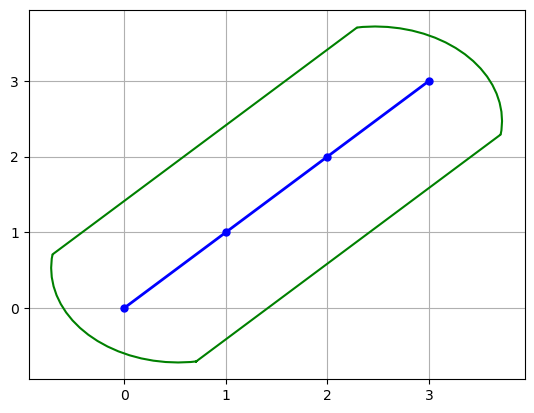

In [33]:
fig, ax = plt.subplots()

x1, y1 = final_squashed_buffer.exterior.xy
ax.plot(x1, y1, color='green', label='flat')

x, y = line.xy
ax.plot(x, y, color='blue', linewidth=2, marker='o', markersize=5, label='LineString')

plt.grid(True)

# Show the plot
plt.show()

Finally, let's put all the logic together into a function

I've added some defensive checks to ensure the input shape has at least 2 points.

Using this with real data, you may also consider sorting your points (by changing the function or adding a conditioning step before running).

In [34]:
points = sorted(points, key=lambda x: x[0])

In [ ]:
def st_buffer_squashed(linestring, buffer_radius, end_cap_radius):
    import numpy as np
    import shapely
    from shapely.geometry import LineString
    from shapely.geometry import Point
    from shapely.geometry import Polygon
    
    import warnings
    if end_cap_radius > buffer_radius:
        warnings.warn("end_cap_radius > buffer_radius. Truncating end_cap_radius", UserWarning)
        end_cap_radius = buffer_radius
    if end_cap_radius < 0:
        warnings.warn("end_cap_radius < 0. Returning flat cap buffer", UserWarning)
        return linestring.buffer(buffer_radius, cap_style='flat')
    
    
    first_two_points = list(linestring.coords[:2])
    line_first_two_points = LineString(first_two_points)
    first_two_x, first_two_y = line_first_two_points.xy
    
    last_two_points = list(linestring.coords[-2:])
    line_last_two_points = LineString(last_two_points)
    last_two_x, last_two_y = line_last_two_points.xy
    
    ### handle inf slope
    if first_two_x[1] == first_two_x[0]:
        first_two_x[1] += 0.000001
    if last_two_x[1] == last_two_x[0]:
        last_two_x[1] += 0.000001
        
    first_two_slope = (first_two_y[1] - first_two_y[0])/(first_two_x[1] - first_two_x[0])
    last_two_slope = (last_two_y[1] - last_two_y[0])/(last_two_x[1] - last_two_x[0])

    cap_buffer_ratio = end_cap_radius / buffer_radius
    
    ### distance to move off from first point or last point to get center of circle
    circle_center_distance = (1-cap_buffer_ratio**2)/(2*cap_buffer_ratio) * buffer_radius
    ### radius of circle that will define squashed end
    circle_radius = np.sqrt(circle_center_distance**2 + buffer_radius**2)
    
    start_posn_delta_x = np.sqrt(circle_center_distance**2 / (1 + first_two_slope**2))
    if first_two_x[1] < first_two_x[0]:
        start_posn_delta_x *= -1
    start_posn_delta_y = first_two_slope * start_posn_delta_x

    end_posn_delta_x = np.sqrt(circle_center_distance**2 / (1 + last_two_slope**2))
    if last_two_x[1] < last_two_x[0]:
        end_posn_delta_x *= -1
    end_posn_delta_y = last_two_slope * end_posn_delta_x

    start_circle_x_center = first_two_x[0] + start_posn_delta_x
    start_circle_y_center = first_two_y[0] + start_posn_delta_y

    end_circle_x_center = last_two_x[1] - end_posn_delta_x
    end_circle_y_center = last_two_y[1] - end_posn_delta_y
    
    start_circle_center = Point(start_circle_x_center, start_circle_y_center)
    end_circle_center = Point(end_circle_x_center, end_circle_y_center)

    # Create a circular polygon using the buffer method
    start_circle = start_circle_center.buffer(circle_radius)
    end_circle = end_circle_center.buffer(circle_radius)
    
    ### st functions
    buffer_flat = linestring.buffer(buffer_radius, cap_style='flat')
    start_round = Point(first_two_x[0],first_two_y[0]).buffer(buffer_radius)
    end_round = Point(last_two_x[1],last_two_y[1]).buffer(buffer_radius)
    buffer_difference_start = start_round.difference(buffer_flat)
    buffer_difference_end = end_round.difference(buffer_flat)
    
    start_cap_squashed = buffer_difference_start.intersection(start_circle)
    end_cap_squashed = buffer_difference_end.intersection(end_circle)
    
    final_squashed_buffer = buffer_flat.union(start_cap_squashed).union(end_cap_squashed)
    return final_squashed_buffer